# Devoir 4 : Analyse de trains de spike d'un réseaux
---

Dans le dernier TD, nous avons vu comment générer une séquence de temps de spike (un train de spike) avec certaines caractéristiques : une probabilité constante d'émission de spike dans le temps, qui résulte dans une distribution exponentielle de temps inter-spike (ISIs), avec un CV proche de 1 (égale à 1 dans la limite des séquences très longues). 

Dans ce devoir, on va répéter l'analyse de trains spike pour une *ensemble* de neurones, c'est-à-dire pour plusieurs neurones à la fois. Cela permet notamment d'étudier le taux de décharge *instantané* de la population, qui est une moyenne sur la population de neurones dans un interval court, et non pas la moyenne sur la durée totale de l'enregistrement des spikes. 

### 0. Préparation / rappel : le `numpy.array` à deux dimensions

Vous avez déjà une notion de ce que c'est un `numpy.array` : jusqu'ici, nous nous sommes servi comme une sorte de liste d'élements avec quelques fonctions supplémentaires, notamment mathématiques. On peut facilement utiliser un array dans des opérations comme la substration, addition, multiplication etc. On peut indexer ses éléments comme dans une liste, ou par ex. `my_array[0]` désigne le premier élément.

Un autre (très) grand avantage des arrays sur les listes c'est qu'ils peuvent avoir plusieurs dimensions, comme par ex. en deux dimensions les matrices avec un certain nombre de rangés et un certain nombre de colonnes. Dans ce cas, l'indexation suit les mêmes principes, mais permet de choisir des élements individuelles, rangés, colonnes, ou sous-matrices selon le nombre d'indexes qu'on utilise. Voici quelques examples :

In [126]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

In [73]:
a = np.array([[0,1], 
              [2,3]])

print(a)

# Avec un seul index on choisit soit 
# la rangé (rangé i avec a[i]) :
print(a[0])

# soit la colonne (colonne i avec a[:,i]) :
print(a[:,1])

# Avec deux index on choisit l'élement a_ij 
# en notation matricielle :
print(a[0,1])

# Enfin la forme ('shape') de l'array, c'est-à-dire 
# le nombre de rangés et le nombre de colonnes, est 
# donnée par 
print('The shape of our 2x2 square matrix is', a.shape, '! (Ouff, c\'est bon...)')

[[0 1]
 [2 3]]
[0 1]
[1 3]
1
The shape of our 2x2 square matrix is (2, 2) ! (Ouff, c'est bon...)


In [2]:
# On peut également créer des array 'vides'
# ou préremplies de 0 (ou 1) avec une forme 
# souhaitée :
b = np.zeros((2,4))
print(b)

# Allons remplir la première rangé de 1s
b[0] = 1.
print(b)

# et remplissons la deuxième rangé des nombre
# de 0 à 3
b[1] = np.arange(4)
print(b)


[[0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[1. 1. 1. 1.]
 [0. 0. 0. 0.]]
[[1. 1. 1. 1.]
 [0. 1. 2. 3.]]


In [3]:
# Attention : lorsque nous souhaitons attribuer 
# des valeurs à des élements d'un array, il faut 
# que les dimensions soient compatibles !
b[:,-1] = np.arange(4)
# (Ce n'est pas le cas ici...)

ValueError: could not broadcast input array from shape (4) into shape (2)

### 1. Analyse de trains de spike d'une population de neurones

Au lieu de générer une séquence de spikes pour un seul neurone, nous pouvons utiliser les "fonctionnalités matricielles" de `numpy` pour générer des spikes pour toute une population de neurones à la fois. 

Dans un premier temps, on va considérer une activité parfaitement Poissonienne avec une probabilité de décharge constante. Cela correspond à une situation d'activité **asynchrone irrégulière** dans un réseaux cortical. 

Dans une deuxième temps, on considéra une modulation temporelle de la probablité d'émission de spike, qui pourra être detectée au niveau de l'aticvité de la population. Une telle modulation pourrait par ex. avoir son origine dans d'une activité oscillante dans une autre région du cortex qui projette sur ces neurones, ou être généré spontanément dans un réseaux récurrent si l'inhibition récurrente est suffisamment forte. Ce cas correspond à un régime d'activité **synchrone irrégulière**.

**Remarque :** Ici, on va représenter l'activité d'un neurone par une séquence de 0s et de 1s, où la valeur correspond à l'absence ou présence d'unespike au temps discrétisé correspondant. C'est une façon différente de "créer" un train de spike comparé à celui vu la semaine dernière, via un tirage au sort des ISI.

**Rappel sur les nombres aléatoires :** Pour représenter "l'hasard" ou l'aléatoire dans des programmes, on peut utiliser des *générateurs de nombres aléatoires*, qui sont des algorithmes qui peuvent générer des nombres qui sont justement le plus aléatoires possibles, dans la mesure qu'ils remplissent certaines critères comme par ex. de ne pas être corrélés entre eux. Des fonctions liées aux nombres aléatoires et leur génération sont fournies par le module `numpy.random`. Généralement, on a le plus souvent besoin de générer des nombres qui sont distribué uniformenent sur l'interval $[0,1)$, pour cela il existe la fonction `np.random.uniform` : 

In [4]:
 np.random.uniform?

In [5]:
# We can draw a 1D array of random numbers:
print(np.random.uniform(size=5))

# or, for example, a 2D array of random numbers
# distributed between 0 and 1
print(np.random.uniform(size=(2,3)))

[0.12310765 0.50590694 0.15065202 0.327449   0.63910201]
[[0.36766513 0.10279547 0.0481294 ]
 [0.67165138 0.08190098 0.00757597]]


<IPython.core.display.Javascript object>


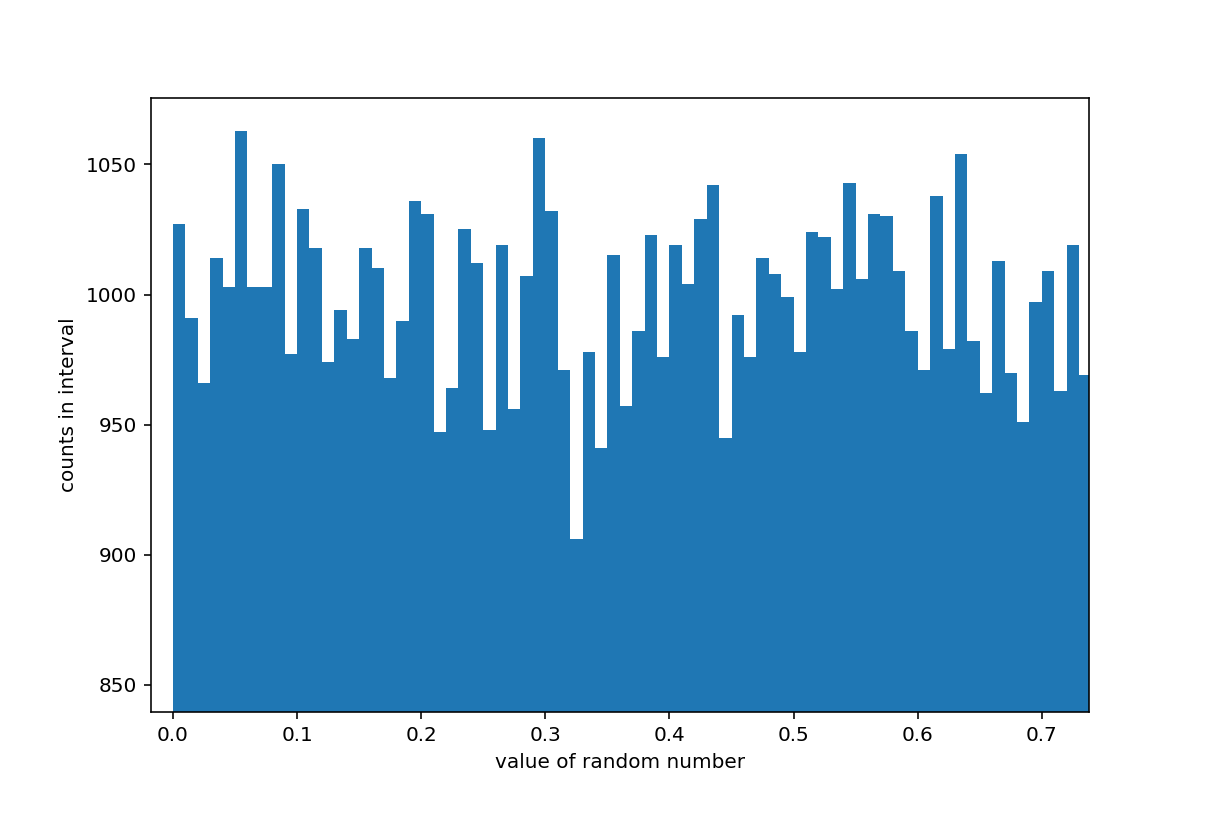

Text(0, 0.5, 'counts in interval')

In [127]:
# Last but not least, let's verify that if 
# we generate many many random numbers, they 
# cover more or less homogeneously the interval
# between 0 and 1:
fig, ax = plt.subplots()
ax.hist(np.random.uniform(size=100000), bins=np.arange(0,1.01,0.01))
ax.set_xlabel('value of random number')
ax.set_ylabel('counts in interval')

# --> so, with a probability of p, the random number is 
# smaller than p, which is what we will use below!


Nous pouvons constater ici que ces nombres aléatoires sont avec une probabilité $p$ plus petit que $p$ - c'est exactement cette propriété que nous avons utilisé dans le dernier TD et que nous allons utiliser par la suite pour déterminer si un PA a été emis à un moment ou pas.

In [75]:
# 1) Parameters of neurons
N = 100    # number of neurons
r = 20.e-3 # firing rate in kHz (=1/ms)

# 3) Discretization of time
T = 20000. # ms
dt = 1.0 # ms
t = np.arange(0,T,dt)
nt = len(t)

# 3) Create matrix with N rows (1st index) representing the neurons
# and nt columns (2nd index) representing the time bins

# probability to record a spike -> constant, single value
# for all neurons and all times
p = dt*r

# here, activities are determined by comparing a N x nt matrix of
# random numbers between 0 and 1 with p
activities = np.random.uniform(size=(N,nt)) < p 

# NOTE: The result of a comparison is a boolean value (i.e, True 
# or False), but we can transform it in 0s and 1s by 
# the (N x nt)-array into integer values
activities = activities.astype(int)


### 1.1 Statistiques 
Calculez le taux de décharge moyen de la population de neurones (en Hz). Est-ce qu'il est en accord avec le taux spécifié ? Déterminez les temps de spike pour les $N$ neurones et déterminez pour chacun le CV et le taux de décharge. Plottez la distribution des CVs. Plottez la distribution des taux de décharge. 

In [76]:
# Taux de décharge moyen :
# compter tous les spikes et
# diviser par le nombre de 
# neurones et le temps total
# NOTE : T en ms, mais taux de
# décharge en 1/s...
nspikes = np.sum(activities)
rate = 1000*nspikes/(T*N) 

print('Le taux de décharge moyen de la population est %.6f Hz'%rate)

Le taux de décharge moyen de la population est 20.026000 Hz


In [78]:
%%timeit
# Extraire les temps de spike

# possibilité 1 : une boucle sur les neurones,
# une boucle sur les temps
spiketimes = [] 
for i in range(N):
    spiketimes.append([]) # rajouter une liste vide 
    for j in range(nt):
        if activities[i,j]==1:
            spiketimes[i].append(dt*j)

1.2 s ± 201 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [87]:
#%%timeit
# possibilité 2 : utiliser np.where pour 
# trouver les indices des entrées avec 1
spiketimes = [] 
for i in range(N):
    time_inds = np.where(activities[i]==1)[0]
    spiketimes.append(dt*time_inds) 

In [80]:
# Calculer les taux, CV
# pour chaque neurone
rates = np.zeros(N)
cvs = np.zeros(N)
for i in range(N):
    rates[i] = 1000*len(spiketimes[i])/T
    isis = np.diff(spiketimes[i])
    # nous pourrions également utiliser les 
    # ISI pour calculer le taux :
    #rates[i] = 1000/np.mean(isis)
    cvs[i] = np.std(isis)/np.mean(isis)

    

Text(0.5, 0, 'rate (Hz)')

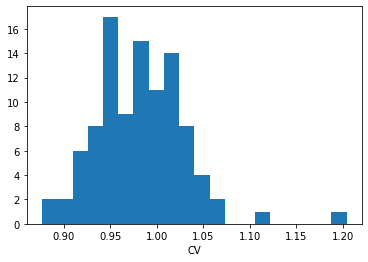

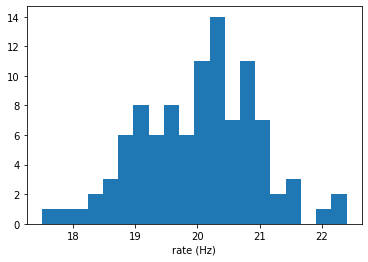

In [81]:
# Plotter les distributions
fig, ax = plt.subplots()
ax.hist(cvs, bins=20)
ax.set_xlabel('CV')


fig, ax = plt.subplots()
ax.hist(rates, bins=20)
ax.set_xlabel('rate (Hz)')

### 1.2 Raster plot

Une visualisation très utile de l'activité neuronale est le "raster plot", où chaque spike est représenté par un point. Ses coordonnées (x,y) représentent le temps du spike (x) et l'identité du neurone (y). Pour un seul neurone avec l'index 0 avec des spikes très réguliers tous les 20 ms cela donnerait 

Text(0, 0.5, 'neuron index')

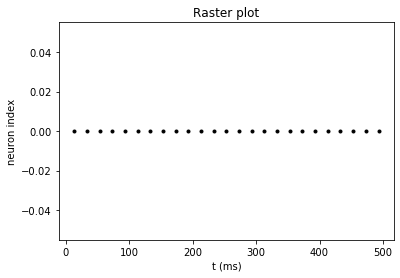

In [85]:
fake_spiketimes = np.arange(13,500,20) 
# Let's take the first spike at t=13ms, of
# course that's absolutely arbitrary!

index = 0

fig, ax = plt.subplots()
ax.set_title('Raster plot')
ax.plot(fake_spiketimes, index*np.ones(len(fake_spiketimes)), marker='.', linewidth=0, color='black')
ax.set_xlabel('t (ms)')
ax.set_ylabel('neuron index')

Généralisez le raster plot à une population de neurones et plottez l'activité de la population de neurones étudiée plus haut. 

**Indice :** Reduisez la durée représentée avec `ax.set_xlim(...)` pour pouvoir distinguer des spikes individuels.

(0, 1000)

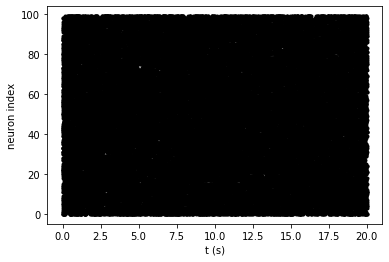

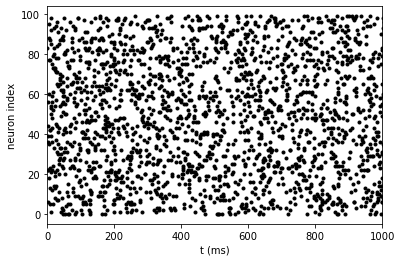

In [88]:
# Raster plot des N neurones
# possibilité 1 : boucle sur les trains de spike
fig, ax = plt.subplots()
for i in range(N):
    ax.plot(spiketimes[i]/1000, i*np.ones(len(spiketimes[i])), marker='.', linewidth=0, color='black')
ax.set_xlabel('t (s)')
ax.set_ylabel('neuron index')

fig, ax = plt.subplots()
for i in range(N):
    ax.plot(spiketimes[i], i*np.ones(len(spiketimes[i])), marker='.', linewidth=0, color='black')
ax.set_xlabel('t (ms)')
ax.set_ylabel('neuron index')
ax.set_xlim(0,1000)

(0, 1000)

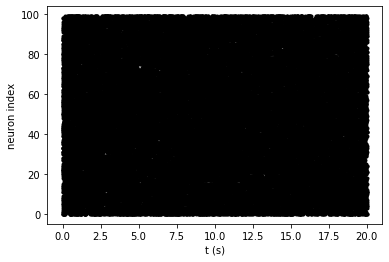

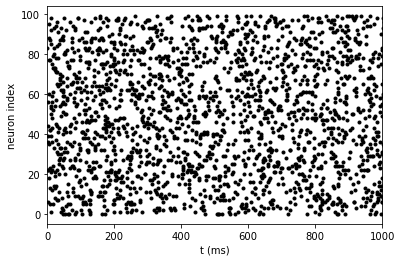

In [89]:
# possibilité 2 : trouver indices 
# et temps de spikes avec np.where

cell_inds, time_inds = np.where(activities)

fig, ax = plt.subplots()
ax.plot(dt*time_inds/1000, cell_inds, marker='.', linewidth=0, color='black')
ax.set_xlabel('t (s)')
ax.set_ylabel('neuron index')

fig, ax = plt.subplots()
ax.plot(dt*time_inds, cell_inds, marker='.', linewidth=0, color='black')
ax.set_xlabel('t (ms)')
ax.set_ylabel('neuron index')
ax.set_xlim(0,1000)

### 1.3 L'activité de population, taux de décharge instantané

Jusqu'ici, nous avons étudié l'activité de neurones avec une décharge irrégulière mais sans variation temporelle sous-jacente. Dans ce cas, on peut s'attendre à ce qu'une moyenne sur beaucoup de neurones (par ex. 1000) sur disons 2 ms donne la même estimation du taux de décharge que la moyenne temporelle pour un neurone sur 2 s. Cela n'est plus valable si la probabilité d'émettre un spike dépend du temps. 

Dans l'exemple suivant, nous allons à nouveau considérer une modulation sinusoidale, ou la probabilité de décharge varie avec le temps selon $p = p_0 + \Delta p \sin(2\pi f_{\rm mod} t)$.

In [99]:
# 1) Parameters of neurons
N = 1000    # number of neurons

# Now, define a baseline firing rate,
# the amplitude of the variation, and 
# a modulation frequency
r0 = 10.e-3 # baseline firing rate in kHz (=1/ms)
dr = 5.e-3  # amplitude of modulation in kHz (=1/ms)
fmod = 20.e-3 # modulation frequency in kHz


# 3) Discretization of time
T = 1000. # ms
dt = 1.0 # ms
t = np.arange(0,T,dt)
nt = len(t)

# 3) Create matrix with N rows (1st index) representing the neurons
# and nt columns (2nd index) representing the time bins

# probability to record a spike -> now, time-dependent array
p = dt*(r0 + dr*np.sin(2*np.pi*fmod*t))

# here, activities are determined by comparing a N x nt matrix of
# random numbers between 0 and 1 with p
activities = np.random.uniform(size=(N,nt)) < p 

# NOTE: The result of a comparison is a boolean value (i.e, True 
# or False), but we can transform it in 0s and 1s 
activities = activities.astype(int)

Déterminez les temps de spike pour les $N$ neurones et plottez l'activité du réseau avec un raster plot. Déterminez à nouveau pour chaque neurone le CV et le taux de décharge, et plottez leurs distributions respectives. 

In [100]:
# possibilité 2 : utiliser np.where pour 
# trouver les indices des entrées avec 1
spiketimes = [] 
for i in range(N):
    time_inds = np.where(activities[i]==1)[0]
    spiketimes.append(dt*time_inds) 

Text(0, 0.5, 'neuron index')

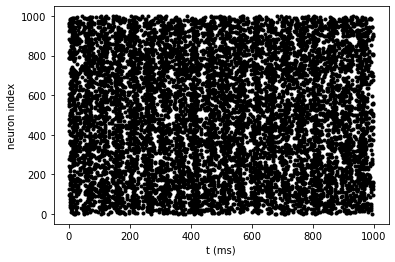

In [101]:
# possibilité 2 : trouver indices 
# et temps de spikes avec np.where

cell_inds, time_inds = np.where(activities)

fig, ax = plt.subplots()
ax.plot(dt*time_inds, cell_inds, marker='.', linewidth=0, color='black')
ax.set_xlabel('t (ms)')
ax.set_ylabel('neuron index')

In [102]:
# Calculer les taux, CV
# pour chaque neurone
rates = np.zeros(N)
cvs = np.zeros(N)
for i in range(N):
    rates[i] = 1000*len(spiketimes[i])/T
    isis = np.diff(spiketimes[i])
    # nous pourrions également utiliser les 
    # ISI pour calculer le taux :
    #rates[i] = 1000/np.mean(isis)
    cvs[i] = np.std(isis)/np.mean(isis)

    

Text(0.5, 0, 'rate (Hz)')

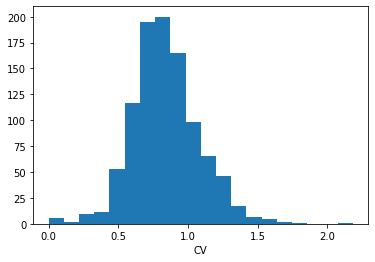

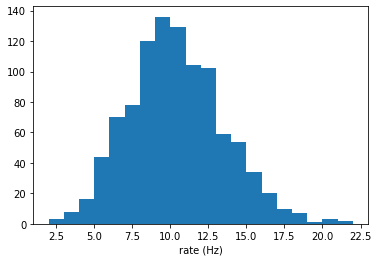

In [103]:
# Plotter les distributions
fig, ax = plt.subplots()
ax.hist(cvs, bins=20)
ax.set_xlabel('CV')


fig, ax = plt.subplots()
ax.hist(rates, bins=20)
ax.set_xlabel('rate (Hz)')

Bien que le raster plot indique que l'activité à l'échelle de la population est régulière, les CVs sont distribués autour de 1, suggérant qu'individuellement l'activité des neurones reste très irrégulière. Pour mieux analyser l'activité de la population, déterminez l'activité moyenne de la population en fonction du temps. Pour cela, utilisez d'abord des bins de 1 ms (vous pouvez choisir d'autres bins plus fins / plus larges pour comparer si vous voulez). 

Vous pourriez partir directement de la matrice contenant l'activité des neurones pour chaque bin que nous avons généré au début, et dont nous nous sommes servis pour déterminez les temps de spikes. Cepandant, la façon plus générale est de partir des $N$ trains de spike (1 pour chaque neuron) et de compter le nombre des spikes dans un bin étant emis dans le réseau.

**Indice :** Si vous avez un array représentant des "bins" de taille `dtbin` , l'index correspondant au bin d'un temps `t` est donné par `i = int(t/dtbin)`.


In [109]:
# Create an empty array that you
# can use to count the spikes in
# a given bin of time [t[i], t[i+1])

# time bins (not necessarily identical to times
# used above for data generation)
dtbin = 4. # ms
tbin = np.arange(0,T,dtbin)
nbins = len(tbin)

# ... votre code pour déterminer le nombre 
# de spikes/PA pour toute la population
# dans chaque bin ...
#
# (solution la plus évidente : boucle sur tous les neurones, 
# puis boucle sur tous les temps de spike de ce neurone)

In [110]:
#%%timeit
# possibilité 1 : 2 x boucle

# array for counts
counts = np.zeros(nbins)

for i in range(N):
    for time in spiketimes[i]:
        counts[int(time/dtbin)] += 1

In [111]:
#%%timeit
# possibilité 2 : la magie des arrays...

# array for counts
counts = np.zeros(nbins)

# Nous avons uniquement besoin des temps de 
# spike, tous les neurones confondus.
# --> Nous pouvons utiliser np.where (voir plus 
# haut) pour trouver les indices des temps
all_spiketimes = dt*time_inds
inds = (all_spiketimes/dtbin).astype(int)

# Rajouter un nombre à 'counts' pour chaque spike
# à l'index donné --> solution la plus élégante (mais
# aussi la plus difficile à trouver) serait d'utiliser
# npp.add.at :
np.add.at(counts, inds, 1)

In [112]:
# Calculer la taux de décharge de la population 
pop_rate = 1000*counts/(N*dtbin)

Plottez l'activité de population en fonction du temps. Quelle valeur pour la largeur des bins (`dtbin`) vous parait bien pour faire sortir la modulation temporelle de l'activité de population, et pourquoi ? Pouvez vous trouver la bonne normalisation pour le nombre des spikes detectés dans un bin (de l'array `counts` ci-dessus) pour obtenir le taux de décharge en Hz ?

(0, 200)

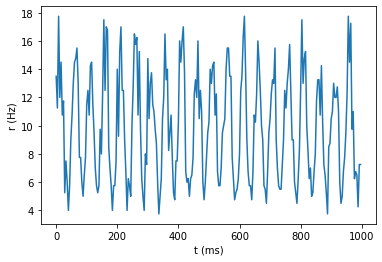

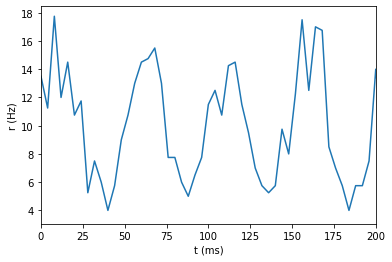

In [113]:
# Plotter l'activité moyenne de la population
fig, ax = plt.subplots()
ax.plot(tbin, pop_rate)
ax.set_xlabel('t (ms)')
ax.set_ylabel('r (Hz)')

fig, ax = plt.subplots()
ax.plot(tbin, pop_rate)
ax.set_xlabel('t (ms)')
ax.set_ylabel('r (Hz)')
ax.set_xlim(0,200)

### BONUS : Activité de population et trains de spike aléatoire avec tirage des ISI d'une distribution exponentielle

Nous avons vu dans le dernier TD que les temps inter-spike (ou ISI) des trains de spike avec une statistique Poissonienne suivent une distribution exponentielle. Vous avez déjà utilisé la fonction `np.random.exponential` pour générer une séquence de ISI et partant des ISI une séquence de temps de spike. 

Essayez de générez `N = 1000` trains de spike qui couvrent chacun l'activité pendant 20s d'un neurone qui décharge à 20Hz. Supposez que tous les neurones émettent un premier PA à $t=0$. 

Déterminez et plottez le taux de décharge moyen de la population en fonction du temps.

(0, 200)

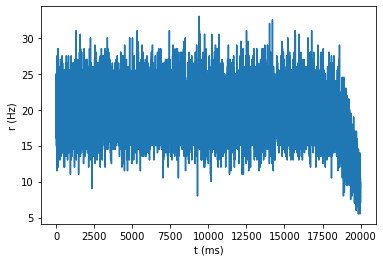

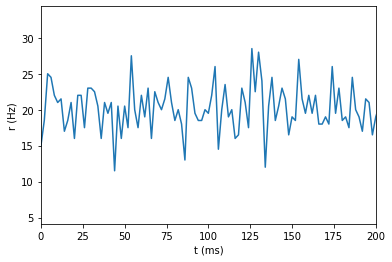

In [114]:
# 1. Générer les ISI
N = 1000
r0 = 20e-3 # kHz
T = 20e3 # ms

# nombre moyen de ISI attendu
# avec un taux de décharge r0
# pour une durée de T :
nisi = int(T*r0)

isis = np.random.exponential(1/r0, size=(N,nisi)) 

# 2. Générer les spiketimes
spiketimes = np.cumsum(isis, axis=1)

# 3. Calculer le taux de décharge de la population
dtbin = 2. # ms
tbin = np.arange(0,T,dtbin)
nbins = len(tbin)

counts = np.zeros(nbins)

# nous pouvons concatener les 
# temps de spike pour chaque neurone
inds = (spiketimes.flatten()/dtbin).astype(int)

# il nous faut enlever les temps de spike
# qui dépassent le temps prévu pour 'counts'
# --> utiliser l'indexation par array boolean
inds = inds[inds<nbins]

np.add.at(counts, inds, 1)

pop_rate = 1000*counts/(N*dtbin)

# 4. Plotter le taux de décharge de la population
fig, ax = plt.subplots()
ax.plot(tbin, pop_rate)
ax.set_xlabel('t (ms)')
ax.set_ylabel('r (Hz)')

fig, ax = plt.subplots()
ax.plot(tbin, pop_rate)
ax.set_xlabel('t (ms)')
ax.set_ylabel('r (Hz)')
ax.set_xlim(0,200)

Maintenant, considerez que chaque neurone décharge de manière régulière avec un faible CV. Pour une décharge à 20Hz, cela correspond à des ISI autour de 50ms. Créez `N = 1000` trains de spike (séquence de temps de spike) avec une ISI moyen de 50ms et un écart-type de 5ms autour de cette valeur moyenne. (Pour couvrir 20s d'activité, cela correspond à env. $r*T=400$ temps de spike.) Utilisez la fonction `np.random.normal` pour tirer des ISI d'une distribution Gaussienne avec la moyenne et l'écart-type donnés. 

Créez un "raster plot" de l'activité et déterminer et plottez le taux de décharge moyen de la population en fonction du temps.

In [115]:
# 1. Générer les ISI
N = 1000
r0 = 20e-3 # kHz
isi = 1/r0 # ms
sigma_isi = 5 # ms
T = 20e3 # ms

# nombre moyen de ISI attendu
# avec un taux de décharge r0
# pour une durée de T :
nisi = int(T*r0)

isis = np.random.normal(isi, sigma_isi, size=(N,nisi)) 

# 2. Générer les spiketimes
spiketimes = np.cumsum(isis, axis=1)

# 3. Calculer le taux de décharge de la population
dtbin = 2. # ms
tbin = np.arange(0,T,dtbin)
nbins = len(tbin)

counts = np.zeros(nbins)

# nous pouvons concatener les 
# temps de spike pour chaque neurone
inds = (spiketimes.flatten()/dtbin).astype(int)

# il nous faut enlever les temps de spike
# qui dépassent le temps prévu pour 'counts'
# --> utiliser l'indexation par array boolean
inds = inds[inds<nbins]

np.add.at(counts, inds, 1)

pop_rate = 1000*counts/(N*dtbin)

(0, 1000)

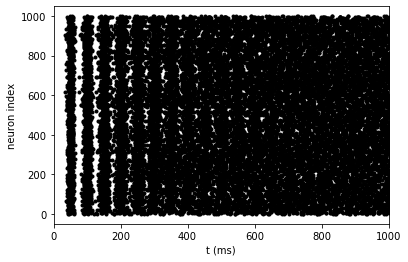

In [116]:
# Raster plot des N neurones
# possibilité 1 : boucle sur les trains de spike
fig, ax = plt.subplots()
for i in range(N):
    ax.plot(spiketimes[i], i*np.ones(len(spiketimes[i])), marker='.', linewidth=0, color='black')
ax.set_xlabel('t (ms)')
ax.set_ylabel('neuron index')
ax.set_xlim(0,1000)

(0, 200)

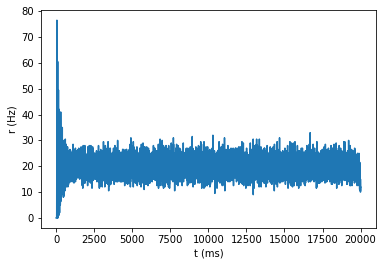

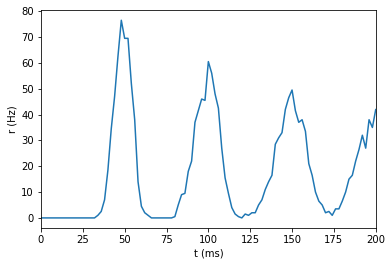

In [72]:
# 4. Plotter le taux de décharge de la population
fig, ax = plt.subplots()
ax.plot(tbin, pop_rate)
ax.set_xlabel('t (ms)')
ax.set_ylabel('r (Hz)')

fig, ax = plt.subplots()
ax.plot(tbin, pop_rate)
ax.set_xlabel('t (ms)')
ax.set_ylabel('r (Hz)')
ax.set_xlim(0,200)

Pouvez-vous expliquer pourquoi la modulation disparaît avec le temps, contrairement à ce qu'on a observé dans le dernier exercise ci-dessus (avant la partie BONUS) ?